# COMP5623 Coursework on Image Caption Generation

Starter code.



In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from  torch.utils.data import Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Text preparation 

We need to build a vocabulary.

In [0]:
# Mounted Drive if using Colab; otherwise, your local path
root = "drive/My Drive/Colab Notebooks/data/Flickr8k/" # <--- replace this with your root data directory
caption_dir = root + "Flickr8k_text/"
image_dir = root + "Flickr8k_Dataset/Flicker8k_Dataset/"
#caption_dir = root + "captions/"                      # <--- replace these too
#image_dir = root + "images/"                           # <---


token_file = "Flickr8k.token.txt"

A helper function to read in our ground truth text file.

In [0]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip())
    file.close() 
    return lines

You can read all the ground truth captions (5 per image), into memory as follows:

In [0]:
lines = read_lines(caption_dir + token_file)

In [6]:
lines[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [0]:
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

Extract all the words from ```lines```, and create a list of them in a variable ```words```, for example:

```words = ["a", "an", "the", "cat"... ]```

No need to worry about duplicates.


In [0]:
import string

lines = read_lines(caption_dir + token_file)
words = []
image_ids = []
cleaned_captions = []

for line in lines:
  img, caption = line.split('\t')
  image_ids.append(img.split('.')[0])
  clean_caption = ""

  for word in caption.split():
    if word not in string.punctuation and word[0] != "'":
     words.append(word.lower())
     clean_caption += word.lower() + ' '

  cleaned_captions.append(clean_caption.strip()) 


Build the vocabulary.

In [0]:
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')


Add the rest of the words from the parsed captions:

``` vocab.add_word('new_word')```

Don't add words that appear three times or less.

In [0]:
#remove words that appear 3 times or less and add to vocabulary

from collections import Counter

a = dict(Counter(words))

for key, value in dict.items(a):
  
  if value > 3:
    vocab.add_word(key)


In [0]:
image_ids[:5]

## Dataset and loaders for training

Keeping the same order, concatenate all the cleaned words from each caption into a string again, and add them all to a list of strings ```cleaned_captions```. Store all the image ids in a list ```image_ids```.

In [50]:
print(len(cleaned_captions))
len(image_ids)

40455


40455

The dataframe for the image paths and captions.

In [0]:
import pandas as pd

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': cleaned_captions
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])

In [11]:
data_df.head(n=5)

image_id  ...                                            caption
0  1000268201_693b08cb0e  ...  a child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e  ...                a girl going into a wooden building
2  1000268201_693b08cb0e  ...     a little girl climbing into a wooden playhouse
3  1000268201_693b08cb0e  ...  a little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e  ...  a little girl in a pink dress going into a woo...

[5 rows x 3 columns]

This is the Flickr8k class for the dataset.

In [0]:
from PIL import Image
import cv2
from nltk import tokenize
from torch.utils.data import Dataset

class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.df)

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

You can read more about it here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [0]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

Now we define the data transform.

In [0]:
from torchvision import transforms

# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [0]:
unit_size = 5

train_split = 0.95 # Defines the ratio of train/test data.

# We didn't shuffle the dataframe yet so this works
train_size = unit_size * round(len(data_df)*train_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

# dataset for 2 images
dataset_two_test_set = Flickr8k(
    df=data_df[(train_size)+80:(train_size)+90].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

#dataset for 5 images
dataset_five_test_set = Flickr8k(
    df=data_df[(train_size)+90:(train_size)+115].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

Write the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

```train_loader = torch.utils.data.DataLoader(
  ...,
  collate_fn=caption_collate_fn
)```

Set train batch size to 128 and be sure to set ```shuffle=True```

In [0]:
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=128,
    shuffle=True,
    #num_workers=2,
    collate_fn=caption_collate_fn
)


test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1, 
    shuffle=False,
    #num_workers=2,
    collate_fn=caption_collate_fn

)
#Data Loader for 2 test set images
two_images_loader = torch.utils.data.DataLoader(
    dataset_two_test_set,
    batch_size=1, 
    shuffle=False,
    num_workers=0,
    collate_fn=caption_collate_fn
)

#data loader for 5 test set images
five_images_loader = torch.utils.data.DataLoader(
    dataset_five_test_set,
    batch_size=1, 
    shuffle=False,
    num_workers=0,
    collate_fn=caption_collate_fn
)

## Encoder and decoder models

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # Complete graph here. Remember to put the ResNet layer in a with torch.no_grad() block
        with torch.no_grad():
          features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))

        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        # self.lstm 
        #self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
      
        # self.rnn
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.rnn(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)          # change to lstm # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [19]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Set training parameters.

In [0]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 1

Initialize the models and set the learning parameters.

In [21]:
import numpy as np

# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


# Evaluation

In [22]:
import nltk
from nltk.probability import FreqDist
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu

def bleu_eval (reference_captions,generated_caption):
  score = 0    
  score = sentence_bleu(reference_captions,tuple(nltk.word_tokenize(generated_caption)))    
  print("The BLEU Score is {}" .format(score))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [64]:
#iterates through data set and shows the batches
iterator = iter(test_loader)
first_img_batch, label1, _ = iterator.next()
second_img_batch, label2, _ = iterator.next()

label2.shape

torch.Size([5, 13])

## Training Preparation

In [0]:
def format_img(img):
    img = img - img.min()
    frmttd_img = img / (img.max()- img.min())
    return frmttd_img

# use the vocab to convert the IDs into words and string the caption together
def id_To_Words (sampled_ids): 
  sampled_caption = []     
  for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        if word == '<start>':
          continue
        
        if word == '<end>':
            break
        sampled_caption.append(word)
  caption_string = ' '.join(sampled_caption)

  return caption_string

In [0]:
def caption_Generator_two_imgs():
  encoder.eval()
  step = 1
  pretrained_captions =[]

  for i, (images, captions, lengths) in enumerate(two_images_loader):

    # image preparation
    if step==1:
      plt.imshow(np.transpose(format_img(images[0].numpy()), (1, 2, 0)))
      plt.title('Sample Image')
      plt.axis('off')
      plt.show()
    print("Reference Caption: " +  id_To_Words(captions[0].cpu().numpy()))
    pretrained_captions.append(tuple(nltk.word_tokenize(id_To_Words(captions[0].cpu().numpy()))))

    if(step % 5)==0:            
      print("Generated Caption: " + id_To_Words(sampled_ids))
      bleu_eval(pretrained_captions,id_To_Words(sampled_ids))
      step=0
      pretrained_captions =[]
    
    
    step +=1

    image_tensor = images.to(device)
    
    # Generate caption
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

 generate a sample caption from two test set
images before any training

Generated Captions Before Training


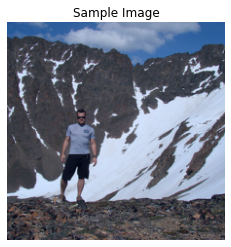

Reference Caption: a man in a gray shirt and black shorts poses in front of a mountain
Reference Caption: a man in a grey t-shirt standing in front of a snow-covered mountain
Reference Caption: a man poses near a mountain
Reference Caption: a man wearing black shorts is standing in front of a snow covered mountain
Reference Caption: a man wearing glasses stands in front of a snowy mountain
Generated Caption: coloring rushing has held greet next garb photographed cop tv smooth jackson keeps machines 12 crocodile shown recently scene apart
The BLEU Score is 0


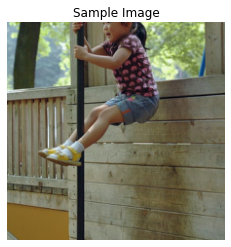

Reference Caption: a girl sliding down a pole
Reference Caption: a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Reference Caption: a young asian girl is sliding down a pole on outdoor playground equipment
Reference Caption: a young girl slides down a bar in a play structure
Reference Caption: a young girl sliding down a black pole
Generated Caption: subway snake pokes knife themselves dragon waterway battles hell leaps curb medieval gazing rounding sweater robot toilet sized snowing movie
The BLEU Score is 0


In [52]:
import matplotlib.pyplot as plt
print("Generated Captions Before Training")
caption_Generator_two_imgs()

## Training the model

The loop to train the model. Feel free to put this in a function if you prefer.

Epoch [0/5], Step [0/301], Loss: 8.1658
Epoch [0/5], Step [10/301], Loss: 4.7288
Epoch [0/5], Step [20/301], Loss: 4.4692
Epoch [0/5], Step [30/301], Loss: 4.2424
Epoch [0/5], Step [40/301], Loss: 4.2011
Epoch [0/5], Step [50/301], Loss: 3.9952
Epoch [0/5], Step [60/301], Loss: 3.8934
Epoch [0/5], Step [70/301], Loss: 3.9511
Epoch [0/5], Step [80/301], Loss: 3.7932
Epoch [0/5], Step [90/301], Loss: 3.7121
Epoch [0/5], Step [100/301], Loss: 3.6937
Epoch [0/5], Step [110/301], Loss: 3.5817
Epoch [0/5], Step [120/301], Loss: 3.5053
Epoch [0/5], Step [130/301], Loss: 3.5039
Epoch [0/5], Step [140/301], Loss: 3.5017
Epoch [0/5], Step [150/301], Loss: 3.3583
Epoch [0/5], Step [160/301], Loss: 3.3981
Epoch [0/5], Step [170/301], Loss: 3.4117
Epoch [0/5], Step [180/301], Loss: 3.2858
Epoch [0/5], Step [190/301], Loss: 3.3360
Epoch [0/5], Step [200/301], Loss: 3.3528
Epoch [0/5], Step [210/301], Loss: 3.2774
Epoch [0/5], Step [220/301], Loss: 3.2708
Epoch [0/5], Step [230/301], Loss: 3.1763
Epo

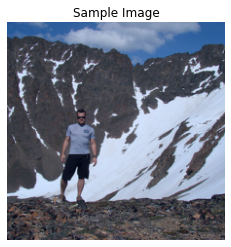

Reference Caption: a man in a gray shirt and black shorts poses in front of a mountain
Reference Caption: a man in a grey t-shirt standing in front of a snow-covered mountain
Reference Caption: a man poses near a mountain
Reference Caption: a man wearing black shorts is standing in front of a snow covered mountain
Reference Caption: a man wearing glasses stands in front of a snowy mountain
Generated Caption: a man in a red shirt is standing on a swing
The BLEU Score is 0.2998221389342337


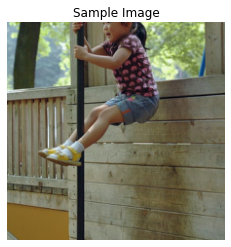

Reference Caption: a girl sliding down a pole
Reference Caption: a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Reference Caption: a young asian girl is sliding down a pole on outdoor playground equipment
Reference Caption: a young girl slides down a bar in a play structure
Reference Caption: a young girl sliding down a black pole
Generated Caption: a man in a red shirt is standing on a swing
The BLEU Score is 0.5972880661844315


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Epoch [1/5], Step [0/301], Loss: 3.0492
Epoch [1/5], Step [10/301], Loss: 3.1254
Epoch [1/5], Step [20/301], Loss: 3.2118
Epoch [1/5], Step [30/301], Loss: 3.1246
Epoch [1/5], Step [40/301], Loss: 3.1321
Epoch [1/5], Step [50/301], Loss: 3.0809
Epoch [1/5], Step [60/301], Loss: 2.8745
Epoch [1/5], Step [70/301], Loss: 3.0155
Epoch [1/5], Step [80/301], Loss: 3.0582
Epoch [1/5], Step [90/301], Loss: 3.0123
Epoch [1/5], Step [100/301], Loss: 2.9798
Epoch [1/5], Step [110/301], Loss: 2.9101
Epoch [1/5], Step [120/301], Loss: 3.0485
Epoch [1/5], Step [130/301], Loss: 3.0051
Epoch [1/5], Step [140/301], Loss: 3.0710
Epoch [1/5], Step [150/301], Loss: 2.9659
Epoch [1/5], Step [160/301], Loss: 2.9795
Epoch [1/5], Step [170/301], Loss: 2.9269
Epoch [1/5], Step [180/301], Loss: 2.9857
Epoch [1/5], Step [190/301], Loss: 2.8692
Epoch [1/5], Step [200/301], Loss: 2.8879
Epoch [1/5], Step [210/301], Loss: 2.8752
Epoch [1/5], Step [220/301], Loss: 2.8475
Epoch [1/5], Step [230/301], Loss: 2.9905
Epo

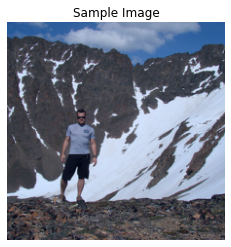

Reference Caption: a man in a gray shirt and black shorts poses in front of a mountain
Reference Caption: a man in a grey t-shirt standing in front of a snow-covered mountain
Reference Caption: a man poses near a mountain
Reference Caption: a man wearing black shorts is standing in front of a snow covered mountain
Reference Caption: a man wearing glasses stands in front of a snowy mountain
Generated Caption: a group of people are standing on a hill
The BLEU Score is 0.6537993517025207


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


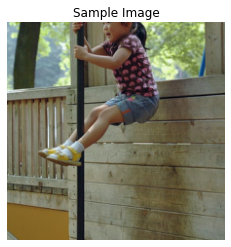

Reference Caption: a girl sliding down a pole
Reference Caption: a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Reference Caption: a young asian girl is sliding down a pole on outdoor playground equipment
Reference Caption: a young girl slides down a bar in a play structure
Reference Caption: a young girl sliding down a black pole
Generated Caption: a young girl in a red shirt is holding a baby in the background
The BLEU Score is 0.3237722713145643


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Epoch [2/5], Step [0/301], Loss: 2.8007
Epoch [2/5], Step [10/301], Loss: 2.6764
Epoch [2/5], Step [20/301], Loss: 2.6903
Epoch [2/5], Step [30/301], Loss: 2.8299
Epoch [2/5], Step [40/301], Loss: 2.7630
Epoch [2/5], Step [50/301], Loss: 2.5774
Epoch [2/5], Step [60/301], Loss: 2.7482
Epoch [2/5], Step [70/301], Loss: 2.7112
Epoch [2/5], Step [80/301], Loss: 2.8034
Epoch [2/5], Step [90/301], Loss: 2.7529
Epoch [2/5], Step [100/301], Loss: 2.7489
Epoch [2/5], Step [110/301], Loss: 2.7689
Epoch [2/5], Step [120/301], Loss: 2.7644
Epoch [2/5], Step [130/301], Loss: 2.6726
Epoch [2/5], Step [140/301], Loss: 2.5849
Epoch [2/5], Step [150/301], Loss: 2.7808
Epoch [2/5], Step [160/301], Loss: 2.6829
Epoch [2/5], Step [170/301], Loss: 2.6559
Epoch [2/5], Step [180/301], Loss: 2.7246
Epoch [2/5], Step [190/301], Loss: 2.6110
Epoch [2/5], Step [200/301], Loss: 2.7306
Epoch [2/5], Step [210/301], Loss: 2.7514
Epoch [2/5], Step [220/301], Loss: 2.6917
Epoch [2/5], Step [230/301], Loss: 2.6909
Epo

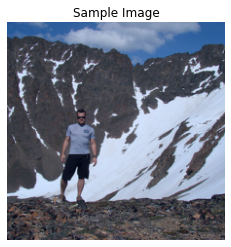

Reference Caption: a man in a gray shirt and black shorts poses in front of a mountain
Reference Caption: a man in a grey t-shirt standing in front of a snow-covered mountain
Reference Caption: a man poses near a mountain
Reference Caption: a man wearing black shorts is standing in front of a snow covered mountain
Reference Caption: a man wearing glasses stands in front of a snowy mountain
Generated Caption: a man in a blue jacket is riding a bike on a dirt road
The BLEU Score is 0.19674979811155635


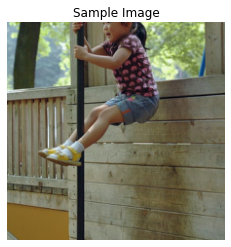

Reference Caption: a girl sliding down a pole
Reference Caption: a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Reference Caption: a young asian girl is sliding down a pole on outdoor playground equipment
Reference Caption: a young girl slides down a bar in a play structure
Reference Caption: a young girl sliding down a black pole
Generated Caption: a young boy wearing a blue shirt is standing on the grass
The BLEU Score is 0.4617366309441026
Epoch [3/5], Step [0/301], Loss: 2.4385
Epoch [3/5], Step [10/301], Loss: 2.4839
Epoch [3/5], Step [20/301], Loss: 2.6273
Epoch [3/5], Step [30/301], Loss: 2.4813
Epoch [3/5], Step [40/301], Loss: 2.6194
Epoch [3/5], Step [50/301], Loss: 2.4201
Epoch [3/5], Step [60/301], Loss: 2.4743
Epoch [3/5], Step [70/301], Loss: 2.5639
Epoch [3/5], Step [80/301], Loss: 2.5985
Epoch [3/5], Step [90/301], Loss: 2.5243
Epoch [3/5], Step [100/301], Loss: 2.5058
Epoch [3/5], Step [

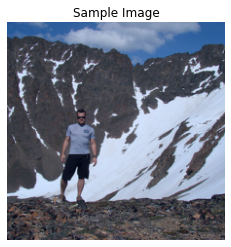

Reference Caption: a man in a gray shirt and black shorts poses in front of a mountain
Reference Caption: a man in a grey t-shirt standing in front of a snow-covered mountain
Reference Caption: a man poses near a mountain
Reference Caption: a man wearing black shorts is standing in front of a snow covered mountain
Reference Caption: a man wearing glasses stands in front of a snowy mountain
Generated Caption: a man in a red jacket is riding a bike
The BLEU Score is 0.2630501434025343


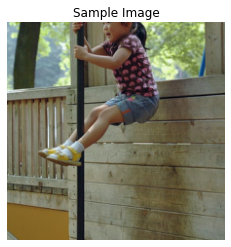

Reference Caption: a girl sliding down a pole
Reference Caption: a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Reference Caption: a young asian girl is sliding down a pole on outdoor playground equipment
Reference Caption: a young girl slides down a bar in a play structure
Reference Caption: a young girl sliding down a black pole
Generated Caption: a little girl in a pink dress is playing with a toy
The BLEU Score is 0.6529942057256104
Epoch [4/5], Step [0/301], Loss: 2.4258
Epoch [4/5], Step [10/301], Loss: 2.3910
Epoch [4/5], Step [20/301], Loss: 2.4140
Epoch [4/5], Step [30/301], Loss: 2.3918
Epoch [4/5], Step [40/301], Loss: 2.3921
Epoch [4/5], Step [50/301], Loss: 2.3399
Epoch [4/5], Step [60/301], Loss: 2.3752
Epoch [4/5], Step [70/301], Loss: 2.4234
Epoch [4/5], Step [80/301], Loss: 2.4568
Epoch [4/5], Step [90/301], Loss: 2.4708
Epoch [4/5], Step [100/301], Loss: 2.4150
Epoch [4/5], Step [110/30

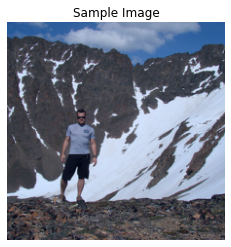

Reference Caption: a man in a gray shirt and black shorts poses in front of a mountain
Reference Caption: a man in a grey t-shirt standing in front of a snow-covered mountain
Reference Caption: a man poses near a mountain
Reference Caption: a man wearing black shorts is standing in front of a snow covered mountain
Reference Caption: a man wearing glasses stands in front of a snowy mountain
Generated Caption: a man in a red shirt is riding a bike down a hill
The BLEU Score is 0.2224246939793677


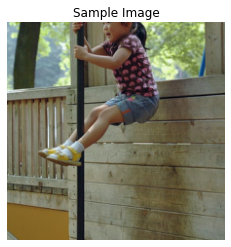

Reference Caption: a girl sliding down a pole
Reference Caption: a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Reference Caption: a young asian girl is sliding down a pole on outdoor playground equipment
Reference Caption: a young girl slides down a bar in a play structure
Reference Caption: a young girl sliding down a black pole
Generated Caption: a boy wearing a blue shirt is jumping off a swing
The BLEU Score is 0.8210967436686386


In [53]:
# Train the models
model_losses = []
model_loss_min = 100.0000
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(train_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        
        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        optimizer.step()


        # Print log 
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item())) 
      
        if loss.item() <= model_loss_min:
            
            torch.save(decoder.state_dict(), root + 'rnn-decoder-model.ckpt')
            torch.save(encoder.state_dict(), root + 'rnn-encoder-model.ckpt')
            
            model_loss_min = loss.item()
            
        model_losses.append(loss.item())
        
    
    #generate a sample caption for the two test set images after Each epoch    
    print("Generated Captions after Epoch number {}" .format(epoch+1))
    caption_Generator_two_imgs()  

# Testing on five images RNN

In [0]:
#generate captions of 5 additional test images using fully trained model
def caption_Generator_five_imgs():
  encoder.eval()
  step = 1
  trained_captions =[]

  for i, (images, captions, lengths) in enumerate(five_images_loader):
    # Prepare an image
    if step==1:
      plt.imshow(np.transpose(format_img(images[0].numpy()), (1, 2, 0)))
      plt.title('Sample Image')
      plt.axis('off')
      plt.show()
    print("Reference Caption: " +  id_To_Words(captions[0].cpu().numpy()))
    
    trained_captions.append(tuple(nltk.word_tokenize(id_To_Words(captions[0].cpu().numpy()))))

    if(step % 5)==0:            
      print("Generated Caption: " + id_To_Words(sampled_ids))      
      bleu_eval(trained_captions,id_To_Words(sampled_ids))
      step=0
      trained_captions =[]
    
    step +=1

    image_tensor = images.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

generate captions for five test set images using trained model

Generated Captions for Five Images after Training


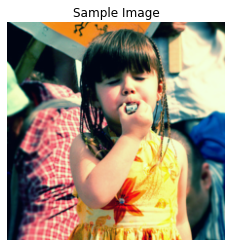

Reference Caption: a girl blows a whistle
Reference Caption: a little girl in a yellow dress with red flowers blows a whistle
Reference Caption: a little girl with a yellow dress blows the whistle
Reference Caption: a small girl blows a whistle
Reference Caption: a young girl in a yellow flowered sundress holds something in her right hand to her mouth
Generated Caption: a young girl in a pink dress is holding a baby in a <unk>
The BLEU Score is 0.24188628508658633


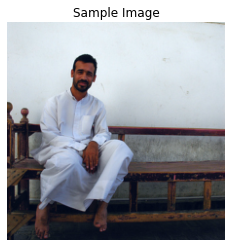

Reference Caption: a bearded man in white clothes is sitting on a long bench
Reference Caption: a man dressed in white sitting on a bench
Reference Caption: a man in a white outfit on a bench
Reference Caption: a man wearing white sits on a wooden bench against a white wall
Reference Caption: an middle eastern man in a white robe is sitting on a wooden bench with his shoes off
Generated Caption: a man in a red shirt and a woman in a red coat and a woman are sitting on
The BLEU Score is 0.1566384057330969


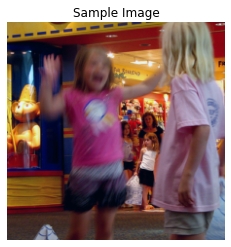

Reference Caption: an <unk> girl in a bright pink shirt is observed by another girl in a light pink shirt
Reference Caption: two children in pink shirts in front of a store with a bear on the sign and on the window
Reference Caption: two girls are standing outside of <unk>
Reference Caption: two little girls in front of the <unk> a bear <unk>
Reference Caption: two young girls play together in a mall
Generated Caption: two young girls are sitting on a wooden bench
The BLEU Score is 0.43472087194499137


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


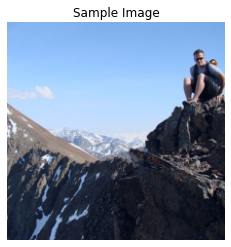

Reference Caption: a male hiker sits perched on a high rock in the mountains
Reference Caption: a man is sitting on a rock high up in the mountains
Reference Caption: a man is sitting on top of a snow covered mountaintop
Reference Caption: a man sits on a rock near mountains
Reference Caption: a man wearing sunglasses is sitting on top of some jagged rocks with mountains in the background
Generated Caption: a man in a red jacket and a helmet is riding a bike down a hill
The BLEU Score is 0.35689978434646996


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


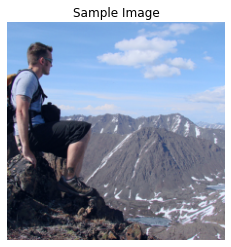

Reference Caption: a man enjoying the view from top of a mountain
Reference Caption: a man in a blue shirt sitting on the side of a mountain wearing a backpack
Reference Caption: a man in grey on a rocky cliff overlooking the mountains
Reference Caption: a man sits on a cliff and looks out over another mountain
Reference Caption: one man wearing a grey shirt and a backpack with snowy mountains in the <unk>
Generated Caption: a man in a red jacket and a backpack is walking on a snowy hill
The BLEU Score is 0.2547001422654908


In [30]:
import matplotlib.pyplot as plt
encoder.load_state_dict(torch.load(root + 'rnn-encoder-model.ckpt'))
decoder.load_state_dict(torch.load(root + 'rnn-decoder-model.ckpt'))

print("Generated Captions for Five Images after Training")
caption_Generator_five_imgs() 

# TRAINNING ON LSTM

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # Complete graph here. Remember to put the ResNet layer in a with torch.no_grad() block
        with torch.no_grad():
          features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))

        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        # self.lstm 
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
      
        # self.rnn
        #self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # change to lstm # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [0]:
def caption_Generator_two_imgs_lstm():
  encoder.eval()
  step = 1
  pretrained_captions =[]

  for i, (images, captions, lengths) in enumerate(two_images_loader):

    # image preparation
    if step==1:
      plt.imshow(np.transpose(format_img(images[0].numpy()), (1, 2, 0)))
      plt.title('Sample Image')
      plt.axis('off')
      plt.show()
    print("Reference Caption: " +  id_To_Words(captions[0].cpu().numpy()))
    pretrained_captions.append(tuple(nltk.word_tokenize(id_To_Words(captions[0].cpu().numpy()))))

    if(step % 5)==0:            
      print("Generated Caption: " + id_To_Words(sampled_ids))
      bleu_eval(pretrained_captions,id_To_Words(sampled_ids))
      step=0
      pretrained_captions =[]
    
    
    step +=1

    image_tensor = images.to(device)
    
    # Generate caption
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

Generates captions of two test set before training

Generated Captions Before Training


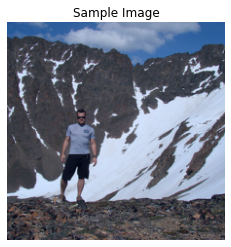

Reference Caption: a man in a gray shirt and black shorts poses in front of a mountain
Reference Caption: a man in a grey t-shirt standing in front of a snow-covered mountain
Reference Caption: a man poses near a mountain
Reference Caption: a man wearing black shorts is standing in front of a snow covered mountain
Reference Caption: a man wearing glasses stands in front of a snowy mountain
Generated Caption: nike one candles claus repelling cold reception derby bouncing advertisements puddles area metal kilt greenish barefooted race ground turtle sash
The BLEU Score is 0


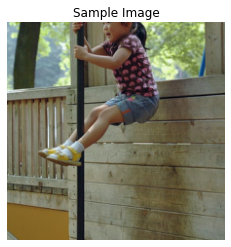

Reference Caption: a girl sliding down a pole
Reference Caption: a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Reference Caption: a young asian girl is sliding down a pole on outdoor playground equipment
Reference Caption: a young girl slides down a bar in a play structure
Reference Caption: a young girl sliding down a black pole
Generated Caption: riverbank monk robes pirate gentleman trains colors motion closeup underwater scuba walking wooded homeless cone female flute control wades sheep
The BLEU Score is 0


In [24]:
import matplotlib.pyplot as plt
print("Generated Captions Before Training")
caption_Generator_two_imgs_lstm()

Epoch [0/5], Step [0/301], Loss: 8.1390
Epoch [0/5], Step [10/301], Loss: 4.7985
Epoch [0/5], Step [20/301], Loss: 4.6768
Epoch [0/5], Step [30/301], Loss: 4.3547
Epoch [0/5], Step [40/301], Loss: 4.1002
Epoch [0/5], Step [50/301], Loss: 4.0416
Epoch [0/5], Step [60/301], Loss: 4.0089
Epoch [0/5], Step [70/301], Loss: 3.9476
Epoch [0/5], Step [80/301], Loss: 3.7368
Epoch [0/5], Step [90/301], Loss: 3.7292
Epoch [0/5], Step [100/301], Loss: 3.7151
Epoch [0/5], Step [110/301], Loss: 3.5563
Epoch [0/5], Step [120/301], Loss: 3.6105
Epoch [0/5], Step [130/301], Loss: 3.6593
Epoch [0/5], Step [140/301], Loss: 3.4360
Epoch [0/5], Step [150/301], Loss: 3.3981
Epoch [0/5], Step [160/301], Loss: 3.4882
Epoch [0/5], Step [170/301], Loss: 3.3717
Epoch [0/5], Step [180/301], Loss: 3.3413
Epoch [0/5], Step [190/301], Loss: 3.4275
Epoch [0/5], Step [200/301], Loss: 3.3501
Epoch [0/5], Step [210/301], Loss: 3.3577
Epoch [0/5], Step [220/301], Loss: 3.3129
Epoch [0/5], Step [230/301], Loss: 3.1560
Epo

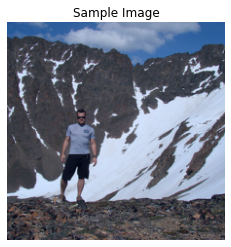

Reference Caption: a man in a gray shirt and black shorts poses in front of a mountain
Reference Caption: a man in a grey t-shirt standing in front of a snow-covered mountain
Reference Caption: a man poses near a mountain
Reference Caption: a man wearing black shorts is standing in front of a snow covered mountain
Reference Caption: a man wearing glasses stands in front of a snowy mountain
Generated Caption: a man in a red shirt is standing on a bench
The BLEU Score is 0.2998221389342337


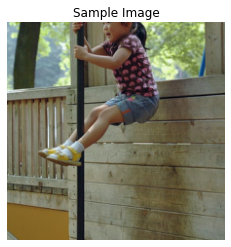

Reference Caption: a girl sliding down a pole
Reference Caption: a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Reference Caption: a young asian girl is sliding down a pole on outdoor playground equipment
Reference Caption: a young girl slides down a bar in a play structure
Reference Caption: a young girl sliding down a black pole
Generated Caption: a man in a red shirt is standing on a bench
The BLEU Score is 0.5972880661844315


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Epoch [1/5], Step [0/301], Loss: 3.2084
Epoch [1/5], Step [10/301], Loss: 3.1154
Epoch [1/5], Step [20/301], Loss: 3.1590
Epoch [1/5], Step [30/301], Loss: 3.0894
Epoch [1/5], Step [40/301], Loss: 3.1051
Epoch [1/5], Step [50/301], Loss: 3.1022
Epoch [1/5], Step [60/301], Loss: 3.1189
Epoch [1/5], Step [70/301], Loss: 3.0558
Epoch [1/5], Step [80/301], Loss: 2.8851
Epoch [1/5], Step [90/301], Loss: 3.1496
Epoch [1/5], Step [100/301], Loss: 2.9575
Epoch [1/5], Step [110/301], Loss: 3.0823
Epoch [1/5], Step [120/301], Loss: 2.9453
Epoch [1/5], Step [130/301], Loss: 3.0375
Epoch [1/5], Step [140/301], Loss: 3.0514
Epoch [1/5], Step [150/301], Loss: 3.0285
Epoch [1/5], Step [160/301], Loss: 2.9879
Epoch [1/5], Step [170/301], Loss: 3.0145
Epoch [1/5], Step [180/301], Loss: 2.8735
Epoch [1/5], Step [190/301], Loss: 2.9552
Epoch [1/5], Step [200/301], Loss: 3.0892
Epoch [1/5], Step [210/301], Loss: 2.8644
Epoch [1/5], Step [220/301], Loss: 2.9414
Epoch [1/5], Step [230/301], Loss: 3.0312
Epo

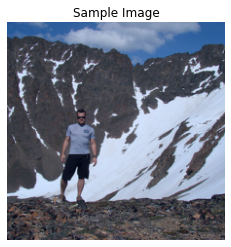

Reference Caption: a man in a gray shirt and black shorts poses in front of a mountain
Reference Caption: a man in a grey t-shirt standing in front of a snow-covered mountain
Reference Caption: a man poses near a mountain
Reference Caption: a man wearing black shorts is standing in front of a snow covered mountain
Reference Caption: a man wearing glasses stands in front of a snowy mountain
Generated Caption: a man in a red shirt is standing on a bench with a <unk>
The BLEU Score is 0.195647514979229


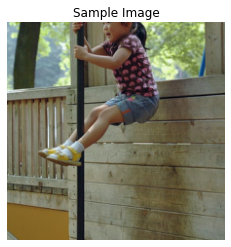

Reference Caption: a girl sliding down a pole
Reference Caption: a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Reference Caption: a young asian girl is sliding down a pole on outdoor playground equipment
Reference Caption: a young girl slides down a bar in a play structure
Reference Caption: a young girl sliding down a black pole
Generated Caption: a man in a red shirt is standing on a bench with a <unk>
The BLEU Score is 0.5791460926441345
Epoch [2/5], Step [0/301], Loss: 2.7887
Epoch [2/5], Step [10/301], Loss: 2.8091
Epoch [2/5], Step [20/301], Loss: 2.7451
Epoch [2/5], Step [30/301], Loss: 2.8483
Epoch [2/5], Step [40/301], Loss: 2.8718
Epoch [2/5], Step [50/301], Loss: 2.8966
Epoch [2/5], Step [60/301], Loss: 2.8312
Epoch [2/5], Step [70/301], Loss: 2.7170
Epoch [2/5], Step [80/301], Loss: 2.8389
Epoch [2/5], Step [90/301], Loss: 2.8249
Epoch [2/5], Step [100/301], Loss: 2.6195
Epoch [2/5], Step [1

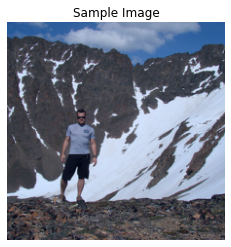

Reference Caption: a man in a gray shirt and black shorts poses in front of a mountain
Reference Caption: a man in a grey t-shirt standing in front of a snow-covered mountain
Reference Caption: a man poses near a mountain
Reference Caption: a man wearing black shorts is standing in front of a snow covered mountain
Reference Caption: a man wearing glasses stands in front of a snowy mountain
Generated Caption: a man in a red shirt is riding a bicycle down a hill
The BLEU Score is 0.2224246939793677


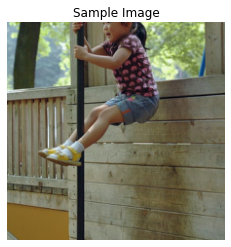

Reference Caption: a girl sliding down a pole
Reference Caption: a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Reference Caption: a young asian girl is sliding down a pole on outdoor playground equipment
Reference Caption: a young girl slides down a bar in a play structure
Reference Caption: a young girl sliding down a black pole
Generated Caption: a girl in a pink dress is standing on a beach
The BLEU Score is 0.7344112539787184
Epoch [3/5], Step [0/301], Loss: 2.5846
Epoch [3/5], Step [10/301], Loss: 2.5411
Epoch [3/5], Step [20/301], Loss: 2.5625
Epoch [3/5], Step [30/301], Loss: 2.5353
Epoch [3/5], Step [40/301], Loss: 2.6103
Epoch [3/5], Step [50/301], Loss: 2.6230
Epoch [3/5], Step [60/301], Loss: 2.5132
Epoch [3/5], Step [70/301], Loss: 2.4592
Epoch [3/5], Step [80/301], Loss: 2.6193
Epoch [3/5], Step [90/301], Loss: 2.6046
Epoch [3/5], Step [100/301], Loss: 2.8098
Epoch [3/5], Step [110/301], Lo

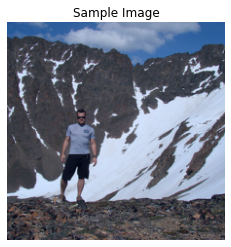

Reference Caption: a man in a gray shirt and black shorts poses in front of a mountain
Reference Caption: a man in a grey t-shirt standing in front of a snow-covered mountain
Reference Caption: a man poses near a mountain
Reference Caption: a man wearing black shorts is standing in front of a snow covered mountain
Reference Caption: a man wearing glasses stands in front of a snowy mountain
Generated Caption: a man in a blue shirt is climbing a rock wall
The BLEU Score is 0.269855346668251


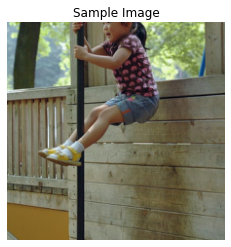

Reference Caption: a girl sliding down a pole
Reference Caption: a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Reference Caption: a young asian girl is sliding down a pole on outdoor playground equipment
Reference Caption: a young girl slides down a bar in a play structure
Reference Caption: a young girl sliding down a black pole
Generated Caption: a young boy wearing a blue shirt is jumping on a trampoline
The BLEU Score is 0.5706745777055999
Epoch [4/5], Step [0/301], Loss: 2.3538
Epoch [4/5], Step [10/301], Loss: 2.4700
Epoch [4/5], Step [20/301], Loss: 2.5832
Epoch [4/5], Step [30/301], Loss: 2.4167
Epoch [4/5], Step [40/301], Loss: 2.6146
Epoch [4/5], Step [50/301], Loss: 2.4051
Epoch [4/5], Step [60/301], Loss: 2.4283
Epoch [4/5], Step [70/301], Loss: 2.5065
Epoch [4/5], Step [80/301], Loss: 2.3184
Epoch [4/5], Step [90/301], Loss: 2.5345
Epoch [4/5], Step [100/301], Loss: 2.4939
Epoch [4/5], Step

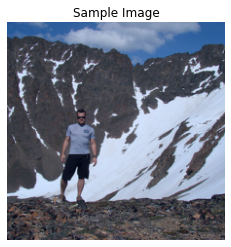

Reference Caption: a man in a gray shirt and black shorts poses in front of a mountain
Reference Caption: a man in a grey t-shirt standing in front of a snow-covered mountain
Reference Caption: a man poses near a mountain
Reference Caption: a man wearing black shorts is standing in front of a snow covered mountain
Reference Caption: a man wearing glasses stands in front of a snowy mountain
Generated Caption: a man in a red jacket is standing on a rock in front of a waterfall
The BLEU Score is 0.33649324423301513


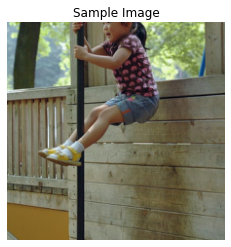

Reference Caption: a girl sliding down a pole
Reference Caption: a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Reference Caption: a young asian girl is sliding down a pole on outdoor playground equipment
Reference Caption: a young girl slides down a bar in a play structure
Reference Caption: a young girl sliding down a black pole
Generated Caption: a young boy wearing a blue shirt is jumping on a trampoline
The BLEU Score is 0.5706745777055999


In [25]:
# Train the models
model_losses = []
model_loss_min = 100.0000
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(train_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        
        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        optimizer.step()


        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item())) 
      
        if loss.item() <= model_loss_min:
            #print('loss decreased   Saving models ...')
            torch.save(decoder.state_dict(), root + 'lstm-decoder-model.ckpt')
            torch.save(encoder.state_dict(), root + 'lstm-encoder-model.ckpt')
            #torch.save(model.state_dict(), output_file)
            model_loss_min = loss.item()
            #improvements.append(epoch - 1)
        model_losses.append(loss.item())
        
    
    #generate a sample caption for the two test set images after Each epoch    
    print("Generated Captions after Epoch number {}" .format(epoch+1))
    caption_Generator_two_imgs_lstm()  

# Testing on five images LSTM

In [0]:
#generate captions of 5 additional test images using fully trained model
def caption_Generator_five_imgs():
  encoder.eval()
  step = 1
  trained_captions =[]

  for i, (images, captions, lengths) in enumerate(five_images_loader):
    # Prepare an image
    if step==1:
      plt.imshow(np.transpose(format_img(images[0].numpy()), (1, 2, 0)))
      plt.title('Sample Image')
      plt.axis('off')
      plt.show()
    print("Reference Caption: " +  id_To_Words(captions[0].cpu().numpy()))
    
    trained_captions.append(tuple(nltk.word_tokenize(id_To_Words(captions[0].cpu().numpy()))))

    if(step % 5)==0:            
      print("Generated Caption: " + id_To_Words(sampled_ids))      
      bleu_eval(trained_captions,id_To_Words(sampled_ids))
      step=0
      trained_captions =[]
    
    step +=1

    image_tensor = images.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

generate captions for five test set images after training using trained model

Generated Captions for Five Images after Training


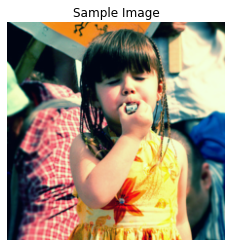

Reference Caption: a girl blows a whistle
Reference Caption: a little girl in a yellow dress with red flowers blows a whistle
Reference Caption: a little girl with a yellow dress blows the whistle
Reference Caption: a small girl blows a whistle
Reference Caption: a young girl in a yellow flowered sundress holds something in her right hand to her mouth
Generated Caption: a young girl in a pink shirt is holding a baby in a park
The BLEU Score is 0.2891784933232572


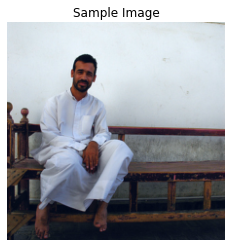

Reference Caption: a bearded man in white clothes is sitting on a long bench
Reference Caption: a man dressed in white sitting on a bench
Reference Caption: a man in a white outfit on a bench
Reference Caption: a man wearing white sits on a wooden bench against a white wall
Reference Caption: an middle eastern man in a white robe is sitting on a wooden bench with his shoes off
Generated Caption: a man in a black shirt and a woman in a red shirt and a woman in a red
The BLEU Score is 0.13400825781778894


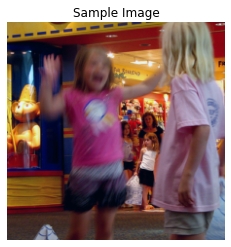

Reference Caption: an <unk> girl in a bright pink shirt is observed by another girl in a light pink shirt
Reference Caption: two children in pink shirts in front of a store with a bear on the sign and on the window
Reference Caption: two girls are standing outside of <unk>
Reference Caption: two little girls in front of the <unk> a bear <unk>
Reference Caption: two young girls play together in a mall
Generated Caption: a young girl in a pink shirt is playing with a red toy
The BLEU Score is 0.41031441132601965


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


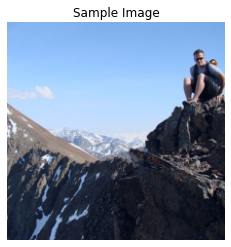

Reference Caption: a male hiker sits perched on a high rock in the mountains
Reference Caption: a man is sitting on a rock high up in the mountains
Reference Caption: a man is sitting on top of a snow covered mountaintop
Reference Caption: a man sits on a rock near mountains
Reference Caption: a man wearing sunglasses is sitting on top of some jagged rocks with mountains in the background
Generated Caption: a man in a red jacket is climbing a rock wall
The BLEU Score is 0.5747078645171895


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


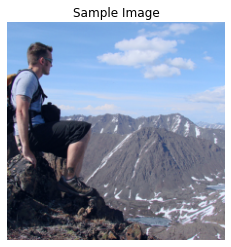

Reference Caption: a man enjoying the view from top of a mountain
Reference Caption: a man in a blue shirt sitting on the side of a mountain wearing a backpack
Reference Caption: a man in grey on a rocky cliff overlooking the mountains
Reference Caption: a man sits on a cliff and looks out over another mountain
Reference Caption: one man wearing a grey shirt and a backpack with snowy mountains in the <unk>
Generated Caption: a man in a red jacket is standing on a rock
The BLEU Score is 0.2790159393585827


In [25]:
import matplotlib.pyplot as plt
encoder.load_state_dict(torch.load(root + 'lstm-encoder-model.ckpt'))
decoder.load_state_dict(torch.load(root + 'lstm-decoder-model.ckpt'))

print("Generated Captions for Five Images after Training")
caption_Generator_five_imgs() 

# Comparing training using an RNN vs LSTM

## RNN: Loss vs Epoch

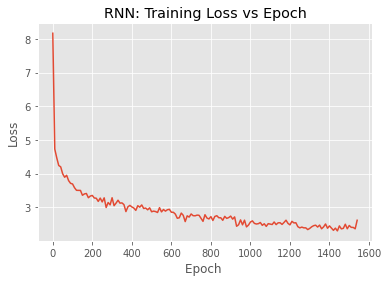

In [16]:
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd

style.use('ggplot')

x,y = np.loadtxt('loss_vs_epoch_rnn.txt',
                  unpack = True,
                  delimiter = ',')

plt.plot(x,y)

plt.title('RNN: Training Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch ')
plt.show()

## LSTM: Loss vs Epoch

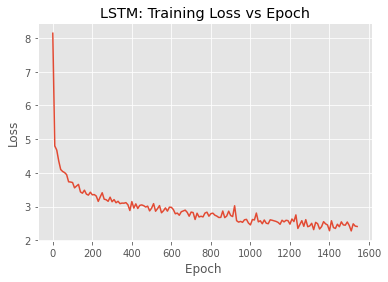

In [2]:
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd

style.use('ggplot')

x,y = np.loadtxt('loss_vs_epoch_lstm.txt',
                  unpack = True,
                  delimiter = ',')

plt.plot(x,y)

plt.title('LSTM: Training Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch ')
plt.show()